In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

'''
Hyper-parameters
'''
# input data
INPUT_SIZE = (128, 64)
INPUT_CHANNEL = 2   # 1-grayscale, 3-RGB scale
OUTPUT_MASK_CHANNEL = 2
# network structure
FILTER_NUM = 32 # number of basic filters for the first layer
FILTER_SIZE = 3 # size of the convolutional filter
DOWN_SAMP_SIZE = 2 # size of pooling filters
UP_SAMP_SIZE = 2 # size of upsampling filters

'''
Definitions of loss and evaluation metrices
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def expend_as(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

# Define a camada personalizada PReLU
class PReLULayer(Layer):
    def __init__(self, alpha_initializer='zeros', **kwargs):
        super(PReLULayer, self).__init__(**kwargs)
        self.alpha_initializer = alpha_initializer

    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha',
                                    shape=(input_shape[-1],),
                                    initializer=self.alpha_initializer,
                                    trainable=True)
        super(PReLULayer, self).build(input_shape)

    def call(self, x):
        return K.maximum(0.0, x) + self.alpha * K.minimum(0.0, x)
# class PReLULayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(PReLULayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         condition = inputs < 0
#         output = tf.where(condition, tf.exp(inputs), inputs + 1)
#         return output

#     def compute_output_shape(self, input_shape):
#         return input_shape


def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    '''
    construction of a double convolutional layer using
    SAME padding
    RELU nonlinear activation function
    :param x: input
    :param filter_size: size of convolutional filter
    :param size: number of filters
    :param dropout: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: output of a double convolutional layer
    '''
    axis = 3
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=axis)(shortcut)

    res_path = layers.add([shortcut, conv])
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :param input:   down-dim feature map
    :param out_size:output channel number
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


def Attention_ResUNet(dropout_rate=0.1, batch_norm=True):
    '''
    Rsidual UNet construction, with attention gate
    convolution: 3*3 SAME padding
    pooling: 2*2 VALID padding
    upsampling: 3*3 VALID padding
    final convolution: 1*1
    :param dropout_rate: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: model
    '''
    # input data
    # dimension of the image depth
    inputs = layers.Input((INPUT_SIZE[0], INPUT_SIZE[1], INPUT_CHANNEL), dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = double_conv_layer(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = double_conv_layer(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = double_conv_layer(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = double_conv_layer(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = double_conv_layer(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # valid padding
    # batch normalization
    # sigmoid nonlinear activation
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    # conv_final = PReLULayer()(conv_final)
    conv_final = layers.Activation('relu')(conv_final)

    conv_final2 = layers.Conv2D(1, kernel_size=(1,1))(up_conv_128)
    conv_final2 = layers.BatchNormalization(axis=axis)(conv_final2)
    conv_final2 = layers.Activation('tanh')(conv_final2)

    final = layers.concatenate([conv_final, conv_final2], axis=-1)

    final = layers.multiply([inputs, final])

    # Model integration
    model = models.Model(inputs, final, name="AttentionResUNet")
    return model

In [2]:
import sys
sys.path.insert(0, '/tf/utils/')

In [3]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Attention, Add, BatchNormalization, Lambda, Activation, Multiply, Dense, Flatten, Input, Concatenate, concatenate, UpSampling2D, LayerNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, Conv2DTranspose
from tensorflow import keras
from keras.callbacks import Callback
from utils import add_white_gaussian_noise, somar_sinais, performance

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import stft, istft
import librosa
from datetime import datetime
from IPython import display

In [4]:
model = Attention_ResUNet(dropout_rate=0.0, batch_norm=False)

In [5]:
from sound import Sound

In [6]:
base_shape_size = 8192
ws = 255
ol = 128
NORM_FACTOR = 128

In [7]:
sound_base = Sound('../../Dados/Vozes/', '../../Dados/Ruido/', base_shape_size, limit=20000)

Loading Noise Files: 100%|██████████| 8137/8137 [00:02<00:00, 2841.41it/s]


In [8]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

In [9]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            x_snr_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # noisy_sound = somar_sinais(sound, noise, sr)
                try:
                    min_valor = np.min(sound)
                    max_valor = np.max(sound)
                    
                    # Defina o novo intervalo desejado
                    novo_min = -0.4
                    novo_max = 0.4
                    
                    # Realize a escala do sinal para o novo intervalo
                    sound_escalado = (sound - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min
    
                    sr = np.random.randint(0, 20, size=(1,)[0])
                    noisy_sound = somar_sinais(sound_escalado, noise, sr)
                    
                    # noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                    noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                    noisy_sound = np.clip(noisy_sound, -1.0, 1.0)
                    
                    A, phi, _, _ = calculate_stft_magnitude_and_phase(sound_escalado)
                    A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)
    
                    
                    # # 1. Calcule a magnitude do ruído em cada frame
                    # Mag_ruido = np.abs(A - A_noisy)
    
                    # # 2. Calcule a SNR para cada frame
                    # P_sinal = np.sum(A**2, axis=0)
                    # P_ruido = np.sum(Mag_ruido**2, axis=0)
                    # SNR = 10 * np.log10(P_sinal / P_ruido)
                    # SNR = SNR.reshape(1, SNR.shape[0], 1)
    
                    # Monta o fasor normalizando a faze por Pi
                    F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                    F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                    
                    # Adiciona o exemplo ao lote de treinamento
                    x_train.append(F_noisy)
                    y_train.append(F)
                except:
                    continue
                # x_snr_train.append(SNR)
                

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            # x_snr_train = np.array(x_snr_train)

            # yield (x_train, x_snr_train), y_train
            yield x_train, y_train

In [10]:
data_generator_train = DataGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = DataGenerator(sound_base.val_X, sound_base.noise_sounds)

In [11]:
model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 32)  608         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 64, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 64, 32)  9248        ['activation[0][0]

In [12]:
model.compile(optimizer='adam', loss='msle')

In [13]:
# Defina sua função de criação de gráfico com base nos dados de validação
def create_plot(x_val, y_val, model):
    F_f = model.predict(x_val, verbose=False)

    indice_aleatorio = np.random.choice(x_val.shape[0])
    x_test = x_val[indice_aleatorio]
    f_test = F_f[indice_aleatorio]
    y_test = y_val[indice_aleatorio]

    A = y_test[:, :, 0]
    phi = (y_test[:, :, 1] - 0.5) * 2 * np.pi
    
    A_f = f_test[:, :, 0]
    phi_f = (f_test[:, :, 1] - 0.5) * 2 * np.pi
    
    A_n = x_test[:, :, 0]
    phi_n = (x_test[:, :, 1] - 0.5) * 2 * np.pi

    s = reconstruct_signal_from_stft(A, phi)
    s_n = reconstruct_signal_from_stft(A_n, phi_n)
    s_f = reconstruct_signal_from_stft(A_f, phi_f)

    display.clear_output(wait=True)

    # Criando figuras e eixos separados para cada array
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    # Plotando o primeiro array
    ax1.plot(s)
    ax1.set_ylabel('Sinal de voz ruidoso')
    
    # Plotando o primeiro array
    ax2.plot(s_n)
    ax2.set_ylabel('Sinal de voz ruidoso')
    
    ax3.plot(s_f)
    ax3.set_ylabel('Sinal de voz filtrado')
    
    # Exibindo os gráficos
    plt.show()

    # display_s = Audio(data=s, rate=8000)
    Audio(data=s, rate=8000)
    # display(display_s)
    # display_n = Audio(data=s_n, rate=8000)
    # display(display_n)
    # display_f = Audio(data=s_f, rate=8000)
    # display(display_f)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Uma linha com três subplots

    # Primeiro gráfico
    im = axs[0].imshow(10*np.log10(A**2), aspect='auto', cmap='inferno')
    axs[0].set_title('Log Power Spectrum - Som original')
    axs[0].set_xlabel('Tempo (s)')
    axs[0].set_ylabel('Frequência (Hz)')
    fig.colorbar(im, ax=axs[0], format='%+2.0f dB')
    
    # Segundo gráfico
    im = axs[1].imshow(10*np.log10(A_n**2), aspect='auto', cmap='inferno')
    axs[1].set_title('Log Power Spectrum - Som ruidoso')
    axs[1].set_xlabel('Tempo (s)')
    axs[1].set_ylabel('Frequência (Hz)')
    fig.colorbar(im, ax=axs[1], format='%+2.0f dB')
    
    # Terceiro gráfico
    im = axs[2].imshow(10*np.log10(A_f**2), aspect='auto', cmap='inferno')
    axs[2].set_title('Log Power Spectrum - Sinal filtrado')
    axs[2].set_xlabel('Tempo (s)')
    axs[2].set_ylabel('Frequência (Hz)')
    fig.colorbar(im, ax=axs[2], format='%+2.0f dB')
    
    plt.tight_layout()  # Para evitar sobreposição de rótulos e gráficos
    plt.show()

# Defina uma classe de callback personalizada para criar o gráfico a cada época
class CreatePlotCallback(Callback):
    def __init__(self, x_val, y_val, model):
        self.x_val = x_val
        self.y_val = y_val
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        create_plot(self.x_val, self.y_val, self.model)

In [14]:
x_val, y_val = next(data_generator_val.generate_sample_completo(batch_size=20))
plot_callback = CreatePlotCallback(x_val, y_val, model)

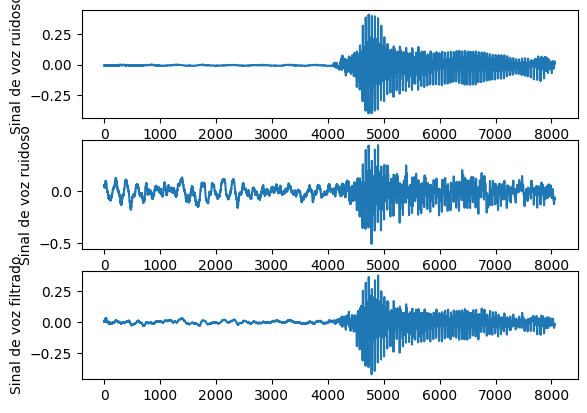

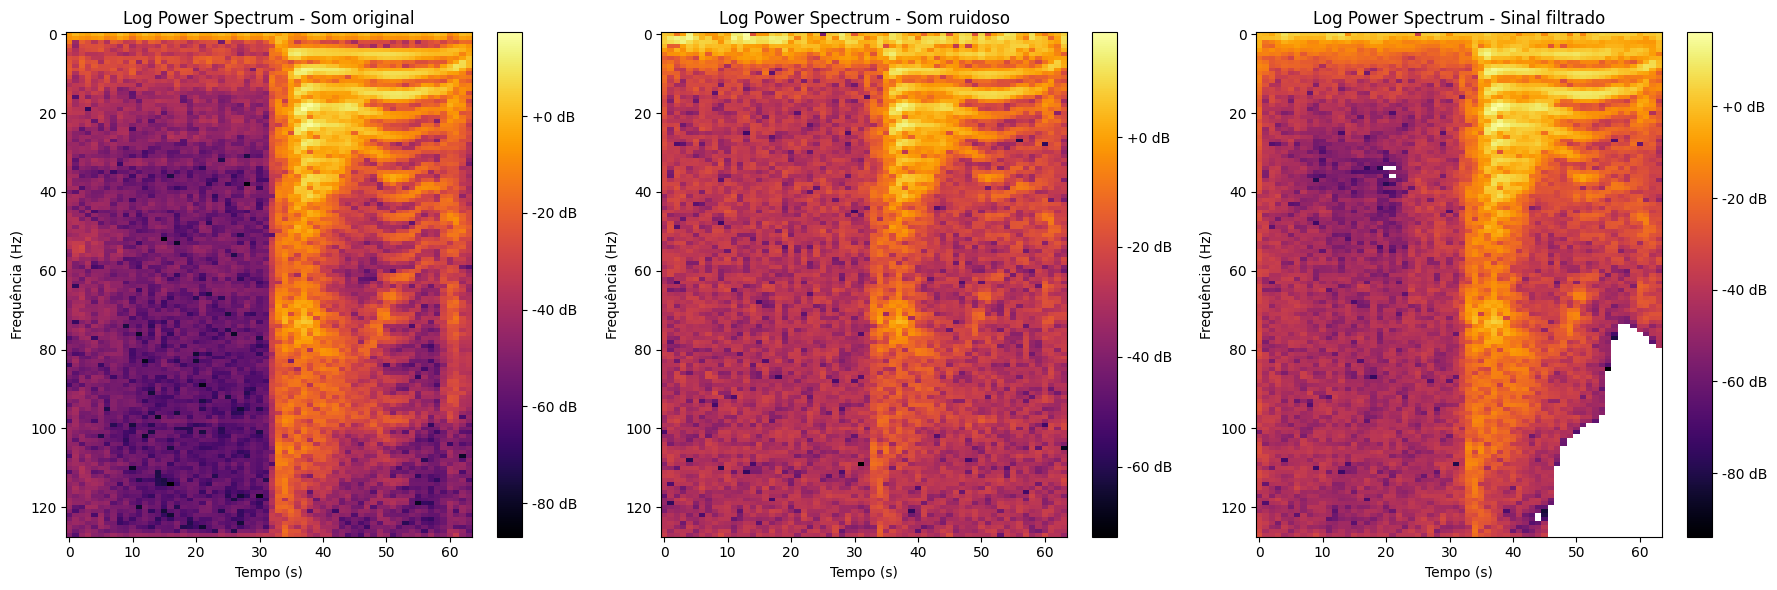

Epoch 26
103/135 [=====================>........] - ETA: 12s - loss: 0.0246

KeyboardInterrupt: 

In [15]:
batch_size = 128
steps_per_epoch = len(sound_base.train_X) // batch_size

print('Starting training')

for epoch in range(150):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
                     # callbacks=[plot_callback]
                    )
    create_plot(x_val, y_val, model)

In [49]:
x_test, y_test = next(data_generator_val.generate_sample_completo(batch_size=1))

In [50]:
F_f = model.predict(x_test)

1/1 [==============================] - 0s 23ms/step


In [51]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
phi_f = (F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

/tmp/ipykernel_11534/1572431701.py:18: RuntimeWarning: divide by zero encountered in log10
  im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')


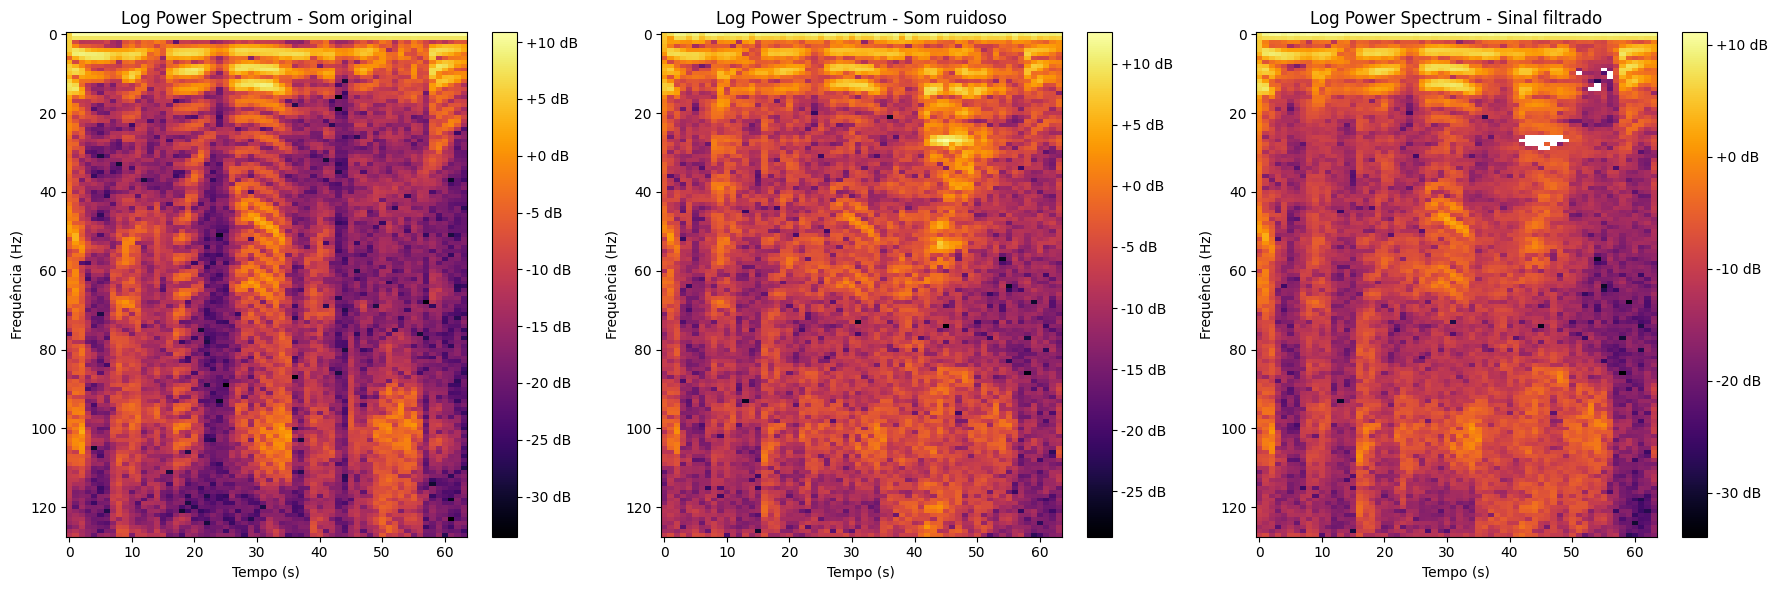

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Uma linha com três subplots

# Primeiro gráfico
im = axs[0].imshow(10*np.log10(A), aspect='auto', cmap='inferno')
axs[0].set_title('Log Power Spectrum - Som original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[0], format='%+2.0f dB')

# Segundo gráfico
im = axs[1].imshow(10*np.log10(A_n), aspect='auto', cmap='inferno')
axs[1].set_title('Log Power Spectrum - Som ruidoso')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[1], format='%+2.0f dB')

# Terceiro gráfico
im = axs[2].imshow(10*np.log10(A_f), aspect='auto', cmap='inferno')
axs[2].set_title('Log Power Spectrum - Sinal filtrado')
axs[2].set_xlabel('Tempo (s)')
axs[2].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[2], format='%+2.0f dB')

plt.tight_layout()  # Para evitar sobreposição de rótulos e gráficos
plt.show()

In [53]:
A.shape

(128, 64)

In [54]:
# spec = 35

# plt.figure(figsize=(12, 6))

# # Primeiro gráfico (A_n)
# plt.subplot(1, 2, 1)
# plt.plot(10*np.log10(A[:, spec]))
# plt.title('Log Power Spectrum de A')
# plt.xlabel('Amostra')
# plt.ylabel('Potência (dB)')
# plt.ylim(10*np.log10(1e-3), 10*np.log10(8))  # Defina os limites y para ambos os gráficos
# plt.grid(True)

# # Segundo gráfico (A)
# plt.subplot(1, 2, 2)
# plt.plot(10*np.log10(A_n[:, spec]))
# plt.title('Log Power Spectrum de A_n')
# plt.xlabel('Amostra')
# plt.ylabel('Potência (dB)')
# plt.ylim(10*np.log10(1e-3), 10*np.log10(8))  # Use os mesmos limites y definidos anteriormente
# plt.grid(True)

# plt.tight_layout()

# plt.show()

In [55]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

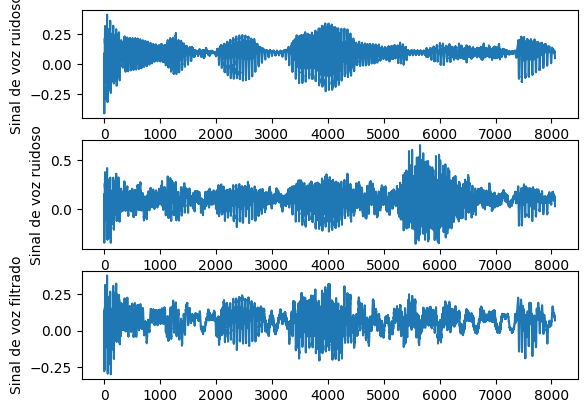

In [56]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [57]:
Audio(data=s, rate=8000)

In [58]:
Audio(data=s_n, rate=8000)

In [59]:
Audio(data=s_f, rate=8000)

In [60]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

model.save('res-unet-STFT-spectral-26-epochs-'+datetime_str+'.h5')